## Is it a bird?
//Updated: 2024-02-10: using search_image_ddg from fastbook.  See lesson Is It a Bird

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

## Step 1: Download images of birds and non-birds

In [ ]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

In [50]:
#from duckduckgo_search import ddg_images
from fastbook import *
from fastcore.all import *

#def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [47]:
urls = search_images_ddg('bird photos', max_images=1)
urls[0]

'https://i.pinimg.com/originals/b8/02/fe/b802fe211686551dbbcd50e9fd0616f7.jpg'

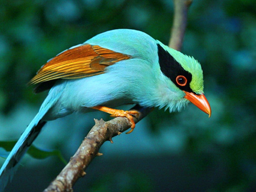

In [40]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

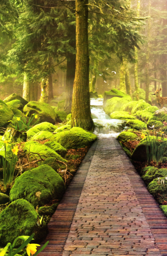

In [42]:
download_url(search_images_ddg('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [43]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep
max_images = 200

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} photo', max_images=max_images))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images_ddg(f'{o} sun photo', max_images=max_images))
    sleep(10)
    download_images(dest, urls=search_images_ddg(f'{o} shade photo', max_images=max_images))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o

## Step 2: Train our model

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

## Step 3: Use our model (and build your own!)

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")